In [ ]:
%autosave 300

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import integrate 
from scipy.optimize import curve_fit

# Bolometric correction

## 1. Intro

### Converting the table rows into arrays

In [2]:
BV_range = np.arange(0.0,1.4,0.1) #ranges mark start-stop-step
BR_range = np.arange(0.1,2.1,0.1)
BI_range = np.arange(-0.4,2.4,0.1)
VR_range = np.arange(-0.2,0.8,0.1)
VI_range = np.arange(-0.7,1.2,0.1)
gi_range = np.arange(-0.8,1.2,0.1)
gr_range = np.arange(-0.3,1.1,0.1)

BV_c0 = -0.083
BV_c1 = -0.139
BV_c2 = -0.691
BV_rms = 0.109

BR_c0 = -0.029
BR_c1 = -0.302
BR_c2 = -0.224
BR_rms = 0.069

BI_c0 = -0.055
BI_c1 = -0.240
BI_c2 = -0.154
BI_rms = 0.061

VR_c0 = 0.197
VR_c1 = -0.183
VR_c2 = -0.419
VR_rms = 0.101

VI_c0 = 0.213
VI_c1 = -0.203
VI_c2 = -0.079
VI_rms = 0.090

gi_c0 = -0.029
gi_c1 = -0.404
gi_c2 = -0.230
gi_rms = 0.060

gr_c0 = 0.054
gr_c1 = -0.195
gr_c2 = -0.719
gr_rms = 0.076

### Cooling phase  fit parameters

In [3]:
cool_BV_range = np.arange(-0.2,0.6,0.1)
cool_BR_range = np.arange(-0.2,0.9,0.1)
cool_BI_range = np.arange(-0.2,0.8,0.1)
cool_VR_range = np.arange(0.0,0.5,0.1)
cool_VI_range = np.arange(0.0,0.5,0.1)
cool_gi_range = np.arange(-0.7,0.2,0.1)
cool_gr_range = np.arange(-0.3,0.4,0.1)

cool_BV_c0 = -0.393
cool_BV_c1 = 0.786
cool_BV_c2 = -2.124
cool_BV_rms = 0.089

cool_BR_c0 = -0.463
cool_BR_c1 = 0.790
cool_BR_c2 = -1.034
cool_BR_rms = 0.078

cool_BI_c0 = -0.473
cool_BI_c1 = 0.830
cool_BI_c2 = -1.064
cool_BI_rms = 0.072

cool_VR_c0 = -0.719
cool_VR_c1 = 4.093
cool_VR_c2 = -6.419
cool_VR_rms = 0.125

cool_VI_c0 = -0.610
cool_VI_c1 = 2.244
cool_VI_c2 = -2.107
cool_VI_rms = 0.146

cool_gi_c0 = -0.158
cool_gi_c1 = -0.459
cool_gi_c2 = -1.599
cool_gi_rms = 0.069

cool_gr_c0 = -0.146
cool_gr_c1 = 0.479
cool_gr_c2 = -2.257
cool_gr_rms = 0.078

## 2. Testing the reproducibility: Appendix B

## Bolometric light curve model from Valenti et al. 2008 MNRAS 383, 1485

In [5]:
import scipy.integrate as integrate
import numpy as np

In [6]:
data = pd.read_excel('SuperNova.xlsx', sheet_name="SN")

# SN 1998bw

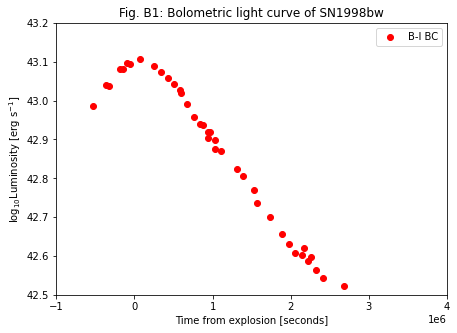

In [7]:
#building sn1998bw from Ildana's google-table data
#
#

SN1998bw = data[[ 'SN 1998bw JD 2450000', 'SN 1998bw Phase', 'SN 1998bw B', 'SN 1998bw V', 'SN 1998bw I']][:72].astype("float")
# SN1998bw["SN1998bw(B_I)"] = SN1998bw['SN 1998bw B'] - SN1998bw['SN 1998bw I']
SN1998bw["SN1998bw(B_V)"] = SN1998bw['SN 1998bw B'] - SN1998bw['SN 1998bw V']
SN1998bw["SN1998bw(V_I)"] = SN1998bw['SN 1998bw V'] - SN1998bw['SN 1998bw I']

# fig, ax = plt.subplots(figsize=(7,5))
# ax.set_xlim(900,1000)
# ax.set_ylim(14.0,16.0)

# ax.scatter(SN1998bw['SN 1998bw JD 2450000'], SN1998bw["SN 1998bw B"], s=3, alpha=0.9, color='red', label="SN1998bw")
# ax = plt.gca()
# plt.gca().invert_yaxis()
# plt.show()

jdtime = SN1998bw['SN 1998bw JD 2450000']
# jdtime = np.append(jdtime, jdtime3)
V = SN1998bw['SN 1998bw V']
# V = np.append(V, V3)
BV = SN1998bw["SN1998bw(B_V)"]
# BV = np.append(BV, BV3)
VI = SN1998bw["SN1998bw(V_I)"]
# VI = np.append(VI, VI3)
###
distmodulus = 32.89 #distance modulus
Ext_BV = 0.065 #extinction B-V
R_V = 3.1 #dust reddeining parameter R_V = A(V) / [A(B)-A(V)]
R_I = 1.5 #dust reddeining parameter R_V = A(I) / [A(B)-A(V)]
Msun = 4.81 #mass of the Sun
Lsun = 3.855e33 #luminosity of the Sun
###
B = BV + V
A_V = R_V * Ext_BV
V_0 = V - A_V
BV_0 = BV - Ext_BV
B_0_BV = BV_0 + V_0
###
I = V - VI
BI = BV + VI
R_I = 1.5 #from Fitzpatrick 1999 Table 2: R_I = A(I)/E(B-V)=1.5
A_I = R_I * Ext_BV
I_0 = I - A_I
BI_0 = B_0_BV - I_0
###
# BolCor_B_0_cool = (-0.393)*(BV_0[0:12])**0 + (+0.786)*(BV_0[0:12])**1 + (-2.124)*(BV_0[0:12])**2
BolCor_B_0 = BV_c0*(BV_0)**0 + BV_c1*(BV_0)**1 + BV_c2*(BV_0)**2

# m_bol_B_0_cool = BolCor_B_0_cool + B_0_BV[0:12] #apparent bolometric magnitude
m_bol_B_0 = BolCor_B_0 + B_0_BV

# M_bol_B_0_cool = m_bol_B_0_cool - distmodulus #absolute bolometric magnitude
M_bol_B_0 = m_bol_B_0 - distmodulus

# L_bol_B_0_cool = 10**(0.4*(Msun-M_bol_B_0_cool))*Lsun
L_bol_B_0 = 10**(0.4*(Msun-M_bol_B_0))*Lsun
###
# BolCor_B_0_cool_BI = (-0.473)*(BI_0[0:12])**0 + (+0.830)*(BI_0[0:12])**1 + (-1.064)*(BI_0[0:12])**2
BolCor_B_0_BI = BI_c0*(BI_0)**0 + BI_c1*(BI_0)**1 + BI_c2*(BI_0)**2

# m_bol_B_0_cool_BI = BolCor_B_0_cool_BI + B_0_BV[0:12] #apparent bolometric magnitude
m_bol_B_0_BI = BolCor_B_0_BI + B_0_BV

# M_bol_B_0_cool_BI = m_bol_B_0_cool_BI - distmodulus #absolute bolometric magnitude
M_bol_B_0_BI = m_bol_B_0_BI - distmodulus

# L_bol_B_0_cool_BI = 10**(0.4*(Msun-M_bol_B_0_cool_BI))*Lsun
L_bol_B_0_BI = 10**(0.4*(Msun-M_bol_B_0_BI))*Lsun
#
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(-1000000,0.4e7)
ax.set_ylim(42.5,43.2)
# 
# plotLbolB0_BVcool = plt.plot(jdtime[0:12]-51.319,np.log10(L_bol_B_0_cool),'D',color='cyan', label='B-V BC cooling phase')
# plotLbolB0_BV = plt.plot(jdtime,np.log10(L_bol_B_0),'D',color='lightseagreen', label='B-V BC')
# plotLbolB0_BVcool_BI = plt.plot(jdtime[0:12]-51.319,np.log10(L_bol_B_0_cool_BI),'o',color='orange', label='B-I BC cooling phase')
plotLbolB0_BV_BI = plt.plot((jdtime-944)*86400,np.log10(L_bol_B_0_BI),'o',color='red', label='B-I BC')

ax.set(title='Fig. B1: Bolometric light curve of SN1998bw',
       xlabel='Time from explosion [seconds]',
       ylabel=r'log$_{10}$Luminosity [erg s$^{-1}$]');
ax.legend()
# plt.show()

# plt.figtext(0.15,0.8,'some text which can be added anywhere in the plot');

# fig.savefig('bolometric_LC_for_1987A.png')

In [8]:
#######we are now working here july 11, 2022
#######here is the last piece of code left to fix
#######namely the code does not work with cirve_fit saying it has less number of datapoints
####### N - number of parameters to fit
####### M - number of datapoints used to fit the parameters
#######see the link1: https://stackoverflow.com/questions/66697003/improper-input-n-2-must-not-exceed-m-1-error-when-attempting-to-fit-lines
#######see the link2: https://stackoverflow.com/questions/65250182/curve-fit-typeerror-improper-input-n-2-must-not-exceed-m-1

import numpy as np
from scipy import integrate
import scipy.optimize
import matplotlib.pyplot as plt
import warnings
  
# suppress warnings
# warnings.filterwarnings('ignore')

eta_Ni = 3.90e10 #[erg/s/g] energy per second per gram
eta_Co = 6.78e9 #[erg/s/g] energy per second per gram
tau_Ni = 524880 #seconds for Nickel-56 half-life = 6.075(10) days from Wiki
tau_Co = 6672931.2 #seconds for Cobalt-56 half-life = 77.233(27) days from Wiki
beta = 13.8
kappa_opt = 0.06 #optical opacity [cm^2 / g] Maeda+ (2003), Valenti+ (2011)
cspeed = 3e10 #speed of light [cm / s]

xdata = np.array((jdtime)) #np.array(xlist) ###making the array out of datapoints
ydata = np.array(L_bol_B_0_BI) #np.array(ylist)

#to sort data by xdata
a = []
for i in range(0,len(xdata)):
    a.append([xdata[i],ydata[i]])

a.sort(key=lambda x:x[0])

xx = []
xdata = []
ydata = []

for i in range(0,len(a)):
    if a[i][0] not in xx:
        xx.append(a[i][0])
        xdata.append((a[i][0]-944)*86400) #days from jd to 0 and to seconds
        ydata.append(a[i][1])
    else:
        print(i)
        

In [9]:
xdata = np.array(xdata)
ydata = np.array(ydata)    

parameter_initial = np.array([0.1e33, 1e33, 1e51]) # a, b, c ###initial estimate for the unknown parameters to be derived
# M_Ni = 0.43e33
# M_ej = 2.5e33
# E_k = 2.7e51

def L_ph(t, M_Ni, M_ej, E_k): #func(x,a,b,c):
#     photospheric_luminosity = np.array([],dtype=np.float128)
    tau_m = (kappa_opt / (beta * cspeed))**0.5 * ((6 * M_ej**3) / (5 * E_k))**0.25
    x = np.array(t / tau_m,dtype=np.float128) #we comment this out since we put tau_m (which is a constant number) explicitly in the equations below
    y = tau_m / (2 * tau_Ni)
    s = (tau_m * (tau_Co - tau_Ni) / (2 * tau_Co * tau_Ni))
#     
    A_z = lambda z: 2 * z * np.exp(-2 * z * y + z**2)
    A_z_integrand = np.asarray([integrate.quad(A_z, 0.0, _x)[0] for _x in x])#,dtype=np.float128)
#     print("A_z",A_z_integrand) #we print in order to check if until this point it works or not
     
    B_z = lambda z: 2 * z * np.exp(-2 * z * y + 2 * z * s + z**2)
    B_z_integrand = np.asarray([integrate.quad(B_z, 0.0, _x)[0] for _x in x])#,dtype=np.float128)
#     print("B_z",B_z_integrand) #we print in order to check if until this point it works or not
    
    exponent_integrand = np.asarray([np.exp((-t/tau_m)**2)])#, dtype=np.float128)#[0] for _t in t])
#     print(exponent_integrand) #we print in order to check if until this point it works or not
#     print(M_Ni * exponent_integrand * ((eta_Ni - eta_Co) * A_z_integrand + eta_Co * B_z_integrand))
    
    
    multuplier1 = [i*M_Ni*(eta_Ni - eta_Co) for i in exponent_integrand]
    multuplier2 = [i*M_Ni*eta_Co for i in exponent_integrand]
    
    print(1,multuplier1)
#     print("2",multuplier2)
    
    photospheric_luminosity = np.asarray([multuplier1 * A_z_integrand + multuplier2 * B_z_integrand])#,dtype=np.float128)
    photospheric_luminosity.shape = (len(t),)
    photospheric_luminosity = [np.float128(f"{i}") for i in photospheric_luminosity]
    
#     print(photospheric_luminosity) #we print in order to check if until this point it works or not
    
#     print(photospheric_luminosity.shape)
    return  photospheric_luminosity


xdata57 = xdata[:39]
ydata57 = ydata[:39]
parameter_optimal, pcov = scipy.optimize.curve_fit(L_ph, xdata, ydata, p0=parameter_initial)#, bounds=(0,np.inf))
print("parameter =", parameter_optimal)

1 [array([1.84284950e+043, 7.29825025e+042, 6.17611133e+042, 4.02054095e+042,
       3.70887843e+042, 3.43620772e+042, 3.29928325e+042, 3.31070529e+042,
       4.78479659e+042, 6.58755304e+042, 9.96382601e+042, 1.63741362e+043,
       2.69333831e+043, 3.00288183e+043, 5.84115963e+043, 1.23907990e+044,
       2.78860322e+044, 3.90157007e+044, 8.16769276e+044, 8.42193016e+044,
       1.17407547e+045, 2.40154451e+045, 2.45576260e+045, 7.14249988e+045,
       1.61255619e+047, 6.62392703e+047, 7.53075128e+048, 1.52534855e+049,
       5.95267373e+050, 1.63249152e+052, 1.54488543e+053, 1.24355753e+054,
       1.19617059e+055, 2.14975014e+055, 1.14507350e+056, 3.52458696e+056,
       1.78564602e+057, 2.46829296e+058, 1.61599633e+062, 3.34594256e+070,
       3.15272160e+074, 1.65396287e+076, 1.00096345e+078, 3.97060372e+078,
       3.53315225e+083, 4.98931088e+103, 8.53797129e+105, 1.98331183e+108,
       3.12249173e+110, 1.84033725e+115, 9.90921390e+117, 1.76774454e+120,
       6.90201207e+122

<ipython-input-9-ab17e4963279>:16: RuntimeWarning: overflow encountered in exp
  A_z = lambda z: 2 * z * np.exp(-2 * z * y + z**2)
<ipython-input-9-ab17e4963279>:20: RuntimeWarning: overflow encountered in exp
  B_z = lambda z: 2 * z * np.exp(-2 * z * y + 2 * z * s + z**2)
<ipython-input-9-ab17e4963279>:24: RuntimeWarning: overflow encountered in exp
  exponent_integrand = np.asarray([np.exp((-t/tau_m)**2)])#, dtype=np.float128)#[0] for _t in t])
<ipython-input-9-ab17e4963279>:29: RuntimeWarning: overflow encountered in multiply
  multuplier1 = [i*M_Ni*(eta_Ni - eta_Co) for i in exponent_integrand]
<ipython-input-9-ab17e4963279>:30: RuntimeWarning: overflow encountered in multiply
  multuplier2 = [i*M_Ni*eta_Co for i in exponent_integrand]


TypeError: Cannot cast array data from dtype('float128') to dtype('float64') according to the rule 'safe'

error: Result from function call is not a proper array of floats.

In [144]:
xdatamodel = np.arange(-5*86400,86400*5, 10, dtype='float')
y = L_ph(xdatamodel, *parameter_optimal)

<ipython-input-145-562a8a0f3545>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(xdatamodel/86400, np.log10(y), '-')


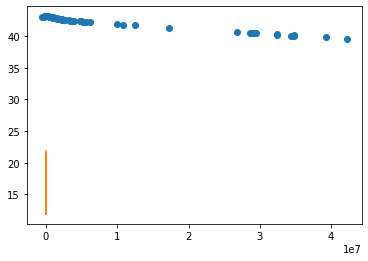

In [145]:
plt.plot(xdata, np.log10(ydata), 'o')
plt.plot(xdatamodel/86400, np.log10(y), '-')
# plt.xlim(-1,0.8)
# plt.ylim(-1e62,1e62)
plt.show()